# cuSpatial Python User's Guide

cuSpatial is a GPU-accelerated Python library for spatial data analysis including distance and  
trajectory computations, spatial data indexing and spatial join operations. cuSpatial's  
Python API provides an accessible interface to high-performance spatial algorithms accelerated
by CUDA-enabled GPUs.

## Contents

This guide provides a working example for all of the python API components of cuSpatial.  
The following list links to each subsection.

* [Installing cuSpatial](#Installing-cuSpatial)
* [GPU accelerated memory layout](#GPU-accelerated-memory-layout)
* [Input / Output](#Input-/-Output)
* [Geopandas and cuDF integration](#Geopandas-and-cuDF-integration)
* [Trajectories](#Trajectories)
* [Bounding](#Bounding)
* [Projection](#Projection)
* [Distance](#Distance)
* [Filtering](#Filtering)
* [Spatial joins](#Spatial-joins)

## Installing cuSpatial
Read the [RAPIDS Quickstart Guide](  https://rapids.ai/start.html     ) to learn more about installing all RAPIDS libraries, including cuSpatial.

If you are working on a system with a CUDA-enabled GPU and have CUDA installed, uncomment the  
following cell and install cuSpatial:

In [1]:
# !conda create -n rapids-22.08 -c rapidsai -c conda-forge -c nvidia \ 
#     cuspatial=22.08 python=3.9 cudatoolkit=11.5 

For other options to create a RAPIDS environment, such as docker or build from source, see  
[RAPIDS Release Selector](  https://rapids.ai/start.html#get-rapids). 

If you wish to contribute to cuSpatial, you should create a source build using the excellent [rapids-compose](https://github.com/trxcllnt/rapids-compose)

## GPU accelerated memory layout

cuSpatial uses `GeoArrow` buffers, a GPU-friendly data format for geometric data that is well  
suited for massively parallel programming. See [I/O]((#Input-/-Output) on the fastest methods to get your  
data into cuSpatial. GeoArrow extends [PyArrow](
https://arrow.apache.org/docs/python/index.html       ) bindings and introduces several new types suited  
for geometry applications.  GeoArrow supports [ListArrays](
https://arrow.apache.org/docs/python/data.html#arrays) for `Points`, `MultiPoints`,  
`LineStrings`, `MultiLineStrings`, `Polygons`, and `MultiPolygons`. Using an Arrow [DenseArray](
https://arrow.apache.org/docs/python/data.html#union-arrays),  
GeoArrow stores heterogeneous types of Features. DataFrames of geometry objects and their  
metadata can be loaded and transformed in a method similar to those in [GeoPandas.GeoSeries](
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.html).

In [2]:
# Imports used throughout this notebook.
import cuspatial
import cudf
import cupy
import geopandas
import pandas as pd
import osmnx as ox
import numpy as np
from shapely.geometry import *

In [3]:
# For deterministic result
np.random.seed(0)
cupy.random.seed(0)

## Input / Output

The primary method of loading features into cuSpatial is using [cuspatial.from_geopandas](
https://docs.rapids.ai/api/cuspatial/stable/api_docs/io.html?highlight=from_geopandas#cuspatial.from_geopandas).

One can also create feature geometries directly using any Python buffer that supports  
`__array_interface__` for coordinates and their feature offsets.

### [cuspatial.from_geopandas](https://docs.rapids.ai/api/cuspatial/stable/api_docs/io.html?highlight=from_geopandas#cuspatial.from_geopandas)

The easiest way to get data into cuSpatial is via `cuspatial.from_geopandas`.

In [4]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path(
    "naturalearth_lowres"
))
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
print(gpu_dataframe.head())

/tmp/ipykernel_261438/3038749724.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path(


       pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  
(GPU)



## Geopandas and cuDF integration

A cuSpatial [GeoDataFrame](
https://docs.rapids.ai/api/cuspatial/stable/api_docs/geopandas_compatibility.html#cuspatial.GeoDataFrame               ) is a collection of [cudf](
https://docs.rapids.ai/api/cudf/stable/              ) [Series](
https://docs.rapids.ai/api/cudf/stable/api_docs/series.html    ) and
[cuspatial.GeoSeries](
https://docs.rapids.ai/api/cuspatial/stable/api_docs/geopandas_compatibility.html#cuspatial.GeoSeries             ) `"geometry"` objects.  
Both types of series are stored on the GPU, and
`GeoSeries` is represented internally using `GeoArrow` data layout.

One of the most important features of cuSpatial is that it is highly integrated with `cuDF`.  
You can use any `cuDF` operation on cuSpatial non-feature columns, and most operations will work  
with a `geometry` column. Operations that reduce or collate the number of rows in your DataFrame,  
for example `groupby`, are not supported at this time.

In [5]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
continents_dataframe = gpu_dataframe.sort_values("name")
print(continents_dataframe)

        pop_est   continent         name iso_a3  gdp_md_est  \
103  38041754.0        Asia  Afghanistan    AFG       19291   
125   2854191.0      Europe      Albania    ALB       15279   
82   43053054.0      Africa      Algeria    DZA      171091   
74   31825295.0      Africa       Angola    AGO       88815   
159      4490.0  Antarctica   Antarctica    ATA         898   
..          ...         ...          ...    ...         ...   
2      603253.0      Africa    W. Sahara    ESH         907   
157  29161922.0        Asia        Yemen    YEM       22581   
70   17861030.0      Africa       Zambia    ZMB       23309   
48   14645468.0      Africa     Zimbabwe    ZWE       21440   
73    1148130.0      Africa     eSwatini    SWZ        4471   

                                              geometry  
103  POLYGON ((66.51861 37.36278, 67.07578 37.35614...  
125  POLYGON ((21.02004 40.84273, 20.99999 40.58000...  
82   POLYGON ((-8.68440 27.39574, -8.66512 27.58948...  
74   MULTIPOLYG

/tmp/ipykernel_261438/567044009.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


You can also convert between GPU-backed `cuspatial.GeoDataFrame` and CPU-backed  
`geopandas.GeoDataFrame` with `from_geopandas`  and `to_geopandas`, enabling you to  
take advantage of any native GeoPandas operation. Note, however, that GeoPandas runs on  
 the CPU and therefore will not have as high performance as cuSpatial operations. The following  
example displays the `Polygon` associated with the first item in the dataframe sorted  
alphabetically by name.

/tmp/ipykernel_261438/1940355512.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


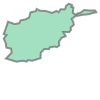

In [6]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
sorted_dataframe = gpu_dataframe.sort_values("name")
host_dataframe = sorted_dataframe.to_geopandas()
host_dataframe['geometry'].iloc[0]

## Trajectories

A trajectory is a `LineString` coupled with a time sample for each point in the `LineString`.  
Use  `cuspatial.trajectory.derive_trajectories` to group trajectory datasets and sort by time.

<img src="../_static/trajectory.png" width=250>

### [cuspatial.derive_trajectories](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.derive_trajectories)

In [7]:
# 1m random trajectory samples
ids = cupy.random.randint(1, 400, 1000000)
timestamps = cupy.random.random(1000000)*1000000
xy= cupy.random.random(2000000)
trajs = cuspatial.GeoSeries.from_points_xy(xy)
sorted_trajectories, trajectory_offsets = \
    cuspatial.core.trajectory.derive_trajectories(ids, trajs, timestamps)
# sorted_trajectories is a DataFrame containing all trajectory samples
# sorted first by `object_id` and then by `timestamp`.
print(sorted_trajectories.head())
# trajectory_offsets is a Series containing the start position of each
# trajectory in sorted_trajectories.
print(trajectory_offsets)

   object_id         x         y               timestamp
0          1  0.680146  0.874341 1970-01-01 00:00:00.125
1          1  0.843522  0.044402 1970-01-01 00:00:00.834
2          1  0.837039  0.351025 1970-01-01 00:00:01.335
3          1  0.946184  0.479038 1970-01-01 00:00:01.791
4          1  0.117322  0.182117 1970-01-01 00:00:02.474
0           0
1        2455
2        4899
3        7422
4        9924
        ...  
394    987408
395    989891
396    992428
397    994975
398    997448
Length: 399, dtype: int32


`derive_trajectories` sorts the trajectories by `object_id`, then `timestamp`, and returns a  
tuple containing the sorted trajectory data frame in the first index position and the offsets  
buffer defining the start and stop of each trajectory in the second index position.  

### [cuspatial.trajectory_distances_and_speeds](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.trajectory_distances_and_speeds)

Use `trajectory_distance_and_speed` to calculate the overall distance travelled in meters and  
the speed of a set of trajectories with the same format as the result returned by `derive_trajectories`.

In [8]:
trajs = cuspatial.GeoSeries.from_points_xy(
    sorted_trajectories[["x", "y"]].interleave_columns()
)
d_and_s = cuspatial.core.trajectory.trajectory_distances_and_speeds(
  len(cudf.Series(ids).unique()),
  sorted_trajectories['object_id'],
  trajs,
  sorted_trajectories['timestamp']
)
print(d_and_s.head())

                   distance        speed
trajectory_id                           
0              1.278996e+06  1280.320089
1              1.267179e+06  1268.370390
2              1.294437e+06  1295.905261
3              1.323413e+06  1323.956714
4              1.309590e+06  1311.561012


Finally, compute the bounding boxes of trajectories that follow the format of the above two  
examples:

## Bounding

Compute the bounding boxes of `n` polygons or linestrings:

<img src="../_static/bounding.png" width=250>

### [cuspatial.trajectory_bounding_boxes](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.trajectory_bounding_boxes)

`trajectory_bounding_boxes` works out of the box with the values returned by `derive_trajectories`.  
Its arguments are the number of incoming objects, the offsets of those objects, and x and y point buffers.

In [9]:
bounding_boxes = cuspatial.core.trajectory.trajectory_bounding_boxes(
  len(cudf.Series(ids, dtype="int32").unique()),
  sorted_trajectories['object_id'],
  trajs
)
print(bounding_boxes.head())

      x_min     y_min     x_max     y_max
0  0.000098  0.000243  0.999422  0.999068
1  0.000663  0.000414  0.999813  0.998456
2  0.000049  0.000220  0.999748  0.999220
3  0.000006  0.000303  0.999729  0.999762
4  0.001190  0.000074  0.999299  0.999858


### [cuspatial.polygon_bounding_boxes](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.polygon_bounding_boxes)

`polygon_bounding_boxes` supports more complex geometry objects such as `Polygon`s with multiple  
rings. The combination of `part_offset` and `ring_offset` allows the function to use only the  
exterior ring for computing the bounding box.

In [10]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
single_polygons = cuspatial.from_geopandas(
    host_dataframe['geometry'][host_dataframe['geometry'].type == "Polygon"]
)
bounding_box_polygons = cuspatial.core.spatial.bounding.polygon_bounding_boxes(
    single_polygons
)
print(bounding_box_polygons.head())

        minx       miny       maxx       maxy
0  29.339998 -11.720938  40.316590  -0.950000
1 -17.063423  20.999752  -8.665124  27.656426
2  46.466446  40.662325  87.359970  55.385250
3  55.928917  37.144994  73.055417  45.586804
4  12.182337 -13.257227  31.174149   5.256088


/tmp/ipykernel_261438/1016569337.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


### [cuspatial.linestring_bounding_boxes](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.linestring_bounding_boxes)

Equivalently, we can treat trajectories as Linestrings and compute the same bounding boxes from  
the above trajectory calculation more generally:

In [11]:
lines = cuspatial.GeoSeries.from_linestrings_xy(
    trajs.points.xy, trajectory_offsets, cupy.arange(len(trajectory_offsets))
)
trajectory_bounding_boxes = cuspatial.core.spatial.bounding.linestring_bounding_boxes(
    lines, 0.0001
)
print(trajectory_bounding_boxes.head())

       minx      miny      maxx      maxy
0 -0.000002  0.000143  0.999522  0.999168
1  0.000563  0.000314  0.999913  0.998556
2 -0.000051  0.000120  0.999848  0.999320
3 -0.000094  0.000203  0.999829  0.999862
4  0.001090 -0.000026  0.999399  0.999958


## Projection

cuSpatial provides a simple sinusoidal longitude / latitude to Cartesian coordinate transform.  
This function requires an origin point to determine the scaling parameters for the lonlat inputs.  

### [cuspatial.sinusoidal_projection](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.sinusoidal_projection)

The following cell converts the lonlat coordinates of the country of Afghanistan to Cartesian  
coordinates in km, centered around the center of the country, suitable for graphing and display.

In [12]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
afghanistan = gpu_dataframe['geometry'][gpu_dataframe['name'] == 'Afghanistan']
points = cuspatial.GeoSeries.from_points_xy(afghanistan.polygons.xy)
projected = cuspatial.sinusoidal_projection(
    afghanistan.polygons.x.mean(),
    afghanistan.polygons.y.mean(),
    points
)
print(projected.head())

0    POINT (112.174 -281.590)
1     POINT (62.152 -280.852)
2     POINT (-5.573 -257.391)
3    POINT (-33.071 -243.849)
4    POINT (-98.002 -279.540)
dtype: geometry


/tmp/ipykernel_261438/2658722012.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


## Distance
cuSpatial provides a growing suite of distance computation functions. Parallel distance functions  
come in two main forms: pairwise, which computes a distance for each corresponding pair of input  
geometries; and all-pairs, which computes a distance for the each element of the Cartesian product  
of input geometries (for each input geometry in A, compute the distance from A to each input
geometry in B)."
    
Two pairwise distance functions are included in cuSpatial: `haversine` and `pairwise_linestring`.  
The `hausdorff` clustering distances algorithm is also available, computing the hausdorff  
distance across the cartesian product of its single input.

### [cuspatial.directed_hausdorff_distance](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.directed_hausdorff_distance)

The directed Hausdorff distance from one space to another is the greatest of all the distances  
between any point in the first space to the closet point in the second. This is especially useful  
as a similarity metric between trajectories.

<img src="../_static/hausdorff.png" width=250>

[Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance)

In [13]:
coordinates = sorted_trajectories[['x', 'y']].interleave_columns()
spaces = cuspatial.GeoSeries.from_multipoints_xy(
    coordinates, trajectory_offsets
)
hausdorff_distances = cuspatial.core.spatial.distance.directed_hausdorff_distance(
    spaces
)
print(hausdorff_distances.head())

        0         1         2         3         4         5         6    \
0  0.000000  0.034755  0.031989  0.031959  0.031873  0.038674  0.029961   
1  0.030328  0.000000  0.038672  0.032086  0.031049  0.032170  0.032275   
2  0.027640  0.030539  0.000000  0.036737  0.033055  0.043447  0.028812   
3  0.031497  0.033380  0.035224  0.000000  0.032581  0.035484  0.030339   
4  0.031079  0.032256  0.035731  0.039084  0.000000  0.036416  0.031369   

        7         8         9    ...       388       389       390       391  \
0  0.029117  0.040962  0.033259  ...  0.031614  0.036447  0.035548  0.028233   
1  0.030215  0.034443  0.032998  ...  0.030594  0.035665  0.031473  0.031916   
2  0.031807  0.039269  0.033250  ...  0.031998  0.033636  0.034646  0.032615   
3  0.034792  0.045755  0.031810  ...  0.033623  0.031359  0.034923  0.032287   
4  0.030388  0.033751  0.034029  ...  0.030705  0.040339  0.034328  0.029027   

        392       393       394       395       396       397  
0  0

### [cuspatial.haversine_distance](https://docs.rapids.ai/api/cuspatial/stable/api_docs/gis.html#cuspatial.haversine_distance)

Haversine distance is the great circle distance between longitude and latitude pairs. cuSpatial  
uses the `lon/lat` ordering to better reflect the cartesian coordinates of great circle  
coordinates: `x/y`.

<img src="../_static/haversine.png" width=250>

In [14]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
polygons_first = gpu_dataframe['geometry'][0:10]
polygons_second = gpu_dataframe['geometry'][10:20]

points_first = polygons_first.polygons.xy[0:1000]
points_second = polygons_second.polygons.xy[0:1000]

first = cuspatial.GeoSeries.from_points_xy(points_first)
second = cuspatial.GeoSeries.from_points_xy(points_second)

# The number of coordinates in two sets of polygons vary, so
# we'll just compare the first set of 1000 values here.
distances_in_meters = cuspatial.haversine_distance(
    first, second
)
cudf.Series(distances_in_meters).head()

/tmp/ipykernel_261438/491857862.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


0    9959.695143
1    9803.166859
2    9876.857085
3    9925.097106
4    9927.268486
Name: None, dtype: float64

### Pairwise distance

`pairwise_linestring_distance` computes the distance between a `GeoSeries` of Linestrings of  
length `n` and a corresponding `GeoSeries` of Linestrings of `n` length. It returns the  
minimum distance from any point in the first linestring of the pair to the nearest segment  
or point within the second Linestring of the pair.

The input accepts a pair of geoseries as input sequences of linestring arrays.

The below example uses the polygons from `naturalearth_lowres` and treats them as linestrings.  
The first example computes the distances between all polygons and themselves, while the second  
example computes the distance between the first 50 polygons and the second 50 polygons.

### [cuspatial.pairwise_linestring_distance](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.pairwise_linestring_distance)

In [15]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))

gpu_boundaries = cuspatial.from_geopandas(host_dataframe.geometry.boundary)
zeros = cuspatial.pairwise_linestring_distance(
    gpu_boundaries[0:50],
    gpu_boundaries[0:50]
)
print(zeros.head())
lines1 = gpu_boundaries[0:50]
lines2 = gpu_boundaries[50:100]
distances = cuspatial.pairwise_linestring_distance(
    lines1, lines2
)
print(distances.head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64
0    152.200610
1     44.076445
2      2.417269
3     44.197151
4     75.821029
dtype: float64


/tmp/ipykernel_261438/1097934054.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


`pairwise_point_linestring_distance` computes the distance between pairs of points and  
linestrings. It can be used with polygons treated as linestrings as well. In the following  
example the minimum distance from a country's center to it's border is computed.

### [cuspatial.pairwise_point_linestring_distance](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.pairwise_point_linestring_distance)

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [16]:
# Convert input dataframe to Pseudo-Mercator projection.
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")).to_crs(3857)
polygons = host_dataframe[host_dataframe['geometry'].type == "Polygon"]
gpu_polygons = cuspatial.from_geopandas(polygons)
# Extract mean_x and mean_y from each country
mean_x = [gpu_polygons['geometry'].iloc[[ix]].polygons.x.mean() for ix in range(len(gpu_polygons))]
mean_y = [gpu_polygons['geometry'].iloc[[ix]].polygons.y.mean() for ix in range(len(gpu_polygons))]
# Convert mean_x/mean_y values into Points for use in API.
points = cuspatial.GeoSeries([Point(point) for point in zip(mean_x, mean_y)])
# Convert Polygons into Linestrings for use in API.
linestring_df = cuspatial.from_geopandas(geopandas.geoseries.GeoSeries(
    [MultiLineString(mapping(polygons['geometry'].iloc[ix])["coordinates"]) for ix in range(len(polygons))]
))
gpu_polygons['border_distance'] = cuspatial.pairwise_point_linestring_distance(
    points, linestring_df
)
print(gpu_polygons.head())

/tmp/ipykernel_261438/2846028812.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")).to_crs(3857)


       pop_est continent             name iso_a3  gdp_md_est  \
1   58005463.0    Africa         Tanzania    TZA       63177   
2     603253.0    Africa        W. Sahara    ESH         907   
5   18513930.0      Asia       Kazakhstan    KAZ      181665   
6   33580650.0      Asia       Uzbekistan    UZB       57921   
11  86790567.0    Africa  Dem. Rep. Congo    COD       50400   

                                             geometry  border_distance  
1   POLYGON ((3774143.866 -105758.362, 3792946.708...      8047.288391  
2   POLYGON ((-964649.018 3205725.605, -964597.245...    593137.492497  
5   POLYGON ((9724867.413 6311418.173, 9640131.701...     37091.213890  
6   POLYGON ((6230350.563 5057973.384, 6225978.591...    278633.467299  
11  POLYGON ((3266113.592 -501451.658, 3286149.877...     35812.988244  
(GPU)



### cuspatial.pairwise_point_polygon_distance

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [17]:
cities = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities")).to_crs(3857)
countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")).to_crs(3857)

gpu_cities = cuspatial.from_geopandas(cities)
gpu_countries = cuspatial.from_geopandas(countries)

dist = cuspatial.pairwise_point_polygon_distance(
    gpu_cities.geometry[:len(gpu_countries)], gpu_countries.geometry
)

gpu_countries["distance_from"] = cities.name
gpu_countries["distance"] = dist

gpu_countries.head()

/tmp/ipykernel_261438/3261459244.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  cities = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities")).to_crs(3857)
/tmp/ipykernel_261438/3261459244.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")).to_crs(3857)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry,distance_from,distance
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((20037508.343 -1812498.413, 200...",Vatican City,1.969350e+07
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((3774143.866 -105758.362, 3792946.708...",San Marino,5.929777e+06
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-964649.018 3205725.605, -964597.245...",Vaduz,3.421172e+06
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...",Lobamba,1.296059e+07
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-13674486.249 6274861.394, -13...",Luxembourg,8.174897e+06


### cuspatial.pairwise_linestring_polygon_distance

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [18]:
# all driveways within 2km range of central park, nyc
graph = ox.graph_from_point((40.769361, -73.977655), dist=2000, network_type="drive")
nodes, streets = ox.graph_to_gdfs(graph)
streets = streets.to_crs(3857)
streets.head()

osmid  oneway   lanes  \
u        v          key                                            
42421769 42443347   0                  195743159    True       3   
42421772 42421769   0                    5668968    True       2   
         42442469   0    [1025731514, 195743132]    True  [3, 4]   
42421775 1061531525 0                    5668968    True       2   
         42428653   0                  404253364    True       4   

                                     name      highway maxspeed reversed  \
u        v          key                                                    
42421769 42443347   0     Columbus Avenue      primary   25 mph    False   
42421772 42421769   0    West 80th Street  residential      NaN    False   
         42442469   0    Amsterdam Avenue      primary      NaN    False   
42421775 1061531525 0    West 80th Street  residential      NaN    False   
         42428653   0            Broadway      primary   25 mph    False   

                          length  \
u        v          key            
42421769 42443347   0     86.010   
42421772 42421769   0    271.702   
         42442469   0     81.618   
42421775 1061531525 0     17.096   
         42428653   0     86.209   

                                                                  geometry  \
u        v          key                                                      
42421769 42443347   0    LINESTRING (-8234860.077 4980333.535, -8234863...   
42421772 42421769   0    LINESTRING (-8235173.854 4980508.442, -8235160...   
         42442469   0    LINESTRING (-8235173.854 4980508.442, -8235168...   
42421775 1061531525 0    LINESTRING (-8235369.475 4980617.398, -8235349...   
         42428653   0    LINESTRING (-8235369.475 4980617.398, -8235373...   

                        access bridge  ref width tunnel junction  
u        v          key                                           
42421769 42443347   0      NaN    NaN  NaN   NaN    NaN      NaN  
42421772 42421769   0      NaN    NaN  NaN   NaN    NaN      NaN  
         42442469   0      NaN    NaN  NaN   NaN    NaN      NaN  
42421775 1061531525 0      NaN    NaN  NaN   NaN    NaN      NaN  
         42428653   0      NaN    NaN  NaN   NaN    NaN      NaN

In [19]:
# The polygon of the Empire State Building
esb = ox.geometries.geometries_from_place('Empire State Building, New York', tags={"building": True})
esb = pd.concat([esb.iloc[0:1]] * len(streets))
esb = esb.to_crs(3857)
esb.head()

nodes  \
element_type osmid                                                         
way          34633854  [402743563, 402743567, 402743571, 402743573, 2...   
             34633854  [402743563, 402743567, 402743571, 402743573, 2...   
             34633854  [402743563, 402743567, 402743571, 402743573, 2...   
             34633854  [402743563, 402743567, 402743571, 402743573, 2...   
             34633854  [402743563, 402743567, 402743571, 402743573, 2...   

                      addr:city addr:housenumber addr:postcode addr:state  \
element_type osmid                                                          
way          34633854  New York              350         10018         NY   
             34633854  New York              350         10018         NY   
             34633854  New York              350         10018         NY   
             34633854  New York              350         10018         NY   
             34633854  New York              350         10018         NY   

                      addr:street building building:colour building:levels  \
element_type osmid                                                           
way          34633854  5th Avenue   office           beige             102   
             34633854  5th Avenue   office           beige             102   
             34633854  5th Avenue   office           beige             102   
             34633854  5th Avenue   office           beige             102   
             34633854  5th Avenue   office           beige             102   

                      building:use  ... office      opening_hours  \
element_type osmid                  ...                             
way          34633854       office  ...    yes  Mo-Su 08:00-02:00   
             34633854       office  ...    yes  Mo-Su 08:00-02:00   
             34633854       office  ...    yes  Mo-Su 08:00-02:00   
             34633854       office  ...    yes  Mo-Su 08:00-02:00   
             34633854       office  ...    yes  Mo-Su 08:00-02:00   

                                 phone start_date     tourism  \
element_type osmid                                              
way          34633854  +1-212-736-3100       1931  attraction   
             34633854  +1-212-736-3100       1931  attraction   
             34633854  +1-212-736-3100       1931  attraction   
             34633854  +1-212-736-3100       1931  attraction   
             34633854  +1-212-736-3100       1931  attraction   

                                              website wheelchair wikidata  \
element_type osmid                                                          
way          34633854  https://www.esbnyc.com/explore        yes    Q9188   
             34633854  https://www.esbnyc.com/explore        yes    Q9188   
             34633854  https://www.esbnyc.com/explore        yes    Q9188   
             34633854  https://www.esbnyc.com/explore        yes    Q9188   
             34633854  https://www.esbnyc.com/explore        yes    Q9188   

                                      wikipedia  \
element_type osmid                                
way          34633854  en:Empire State Building   
             34633854  en:Empire State Building   
             34633854  en:Empire State Building   
             34633854  en:Empire State Building   
             34633854  en:Empire State Building   

                                                                geometry  
element_type osmid                                                        
way          34633854  POLYGON ((-8236139.639 4975314.625, -8235990.3...  
             34633854  POLYGON ((-8236139.639 4975314.625, -8235990.3...  
             34633854  POLYGON ((-8236139.639 4975314.625, -8235990.3...  
             34633854  POLYGON ((-8236139.639 4975314.625, -8235990.3...  
             34633854  POLYGON ((-8236139.639 4975314.625, -8235990.3...  

[5 rows x 35 columns]

In [20]:
# Straight line distance between the driveways to the Empire State Building
gpu_streets = cuspatial.from_geopandas(streets.geometry)
gpu_esb = cuspatial.from_geopandas(esb.geometry)

dist = cuspatial.pairwise_linestring_polygon_distance(gpu_streets, gpu_esb).rename("dist")
pd.concat([streets["name"].reset_index(drop=True), dist.to_pandas()], axis=1)

,name,dist
0,Columbus Avenue,4993.583717
1,West 80th Street,5103.472213
2,Amsterdam Avenue,5208.373183
3,West 80th Street,5276.886560
4,Broadway,5178.999774
...,...,...
1859,East 70th Street,4193.471831
1860,West 65th Street,3999.118604
1861,Dyer Avenue,1470.617115
1862,Dyer Avenue,1468.714127


### cuspatial.pairwise_polygon_distance

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [21]:
countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")).to_crs(3857)
gpu_countries = cuspatial.from_geopandas(countries)

african_countries = gpu_countries[gpu_countries.continent == "Africa"].sort_values("pop_est", ascending=False)
asian_countries = gpu_countries[gpu_countries.continent == "Asia"].sort_values("pop_est", ascending=False)

/tmp/ipykernel_261438/3213563529.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres")).to_crs(3857)


In [22]:
# Straight line distance between the top 10 most populated countries in Asia and Africa
population_top10_africa = african_countries[:10].reset_index(drop=True)
population_top10_asia = asian_countries[:10].reset_index(drop=True)
dist = cuspatial.pairwise_polygon_distance(
    population_top10_africa.geometry, population_top10_asia.geometry)

cudf.concat([
    population_top10_africa["name"].rename("Africa"),
    population_top10_asia["name"].rename("Asia"), 
    dist.rename("dist")], axis=1
)

,Africa,Asia,dist
0,Nigeria,China,7.383366e+06
1,Ethiopia,India,2.883313e+06
2,Egypt,Indonesia,6.776043e+06
3,Dem. Rep. Congo,Pakistan,4.227767e+06
4,South Africa,Bangladesh,8.189086e+06
5,Tanzania,Japan,1.096947e+07
6,Kenya,Philippines,8.399282e+06
7,Uganda,Vietnam,7.773975e+06
8,Algeria,Turkey,2.000180e+06
9,Sudan,Iran,1.625828e+06


## Filtering

The filtering module contains `points_in_spatial_window`, which returns from a set of points only those points that fall within a spatial window defined by four bounding coordinates: `min_x`, `max_x`, `min_y`, and `max_y`. The following example finds only the points of polygons that fall within 1 standard deviation of the mean of all of the polygons.

<img src="../_static/spatial_window.png" width=550>

### [cuspatial.points_in_spatial_window](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.points_in_spatial_window)

In [23]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
geometry = gpu_dataframe['geometry']
points = cuspatial.GeoSeries.from_points_xy(geometry.polygons.xy)
mean_x, std_x = (geometry.polygons.x.mean(), geometry.polygons.x.std())
mean_y, std_y = (geometry.polygons.y.mean(), geometry.polygons.y.std())
avg_points = cuspatial.points_in_spatial_window(
    points,
    mean_x - std_x,
    mean_x + std_x,
    mean_y - std_y,
    mean_y + std_y
)
print(avg_points.head())

0    POINT (33.90371 -0.95000)
1    POINT (34.07262 -1.05982)
2    POINT (37.69869 -3.09699)
3    POINT (37.76690 -3.67712)
4    POINT (39.20222 -4.67677)
dtype: geometry


/tmp/ipykernel_261438/3414785716.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


With some careful grouping, one can reconstruct the original complete polygons that fall within the range.

## Set Operations

### Linestring Intersections

cuSpatial provides a linestring-linestring intersection algorithm to compute the overlapping geometries between two linestrings.
The API also returns the ids for each returned geometry to help user to trace back the source geometry.

In [24]:
from cuspatial.core.binops.intersection import pairwise_linestring_intersection

host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
usa_boundary = cuspatial.from_geopandas(host_dataframe[host_dataframe.name == "United States of America"].geometry.boundary)
canada_boundary = cuspatial.from_geopandas(host_dataframe[host_dataframe.name == "Canada"].geometry.boundary)

list_offsets, geometries, look_back_ids = pairwise_linestring_intersection(usa_boundary, canada_boundary)

/tmp/ipykernel_261438/199363072.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


In [25]:
# The first integer series shows that the result contains 1 row (since we only have 1 pair of linestrings as input).
# This row contains 144 geometires.
list_offsets

[
  0,
  142
]
dtype: int32

In [26]:
# The second element is a geoseries that contains the intersecting geometries, with 144 rows, including points and linestrings.
geometries

0                            POINT (-130.53611 54.80275)
1                            POINT (-130.53611 54.80278)
2                            POINT (-130.53611 54.80275)
3                            POINT (-129.98000 55.28500)
4                            POINT (-130.53611 54.80278)
                             ...                        
137    LINESTRING (-82.69009 41.67511, -82.43928 41.6...
138    LINESTRING (-117.03121 49.00000, -107.05000 49...
139    LINESTRING (-83.89077 46.11693, -83.61613 46.1...
140    LINESTRING (-120.00000 49.00000, -117.03121 49...
141    LINESTRING (-122.84000 49.00000, -120.00000 49...
Length: 142, dtype: geometry

In [27]:
# The third element is a dataframe that contains IDs to the input segments and linestrings, 4 for each result row.
# Each represents ids to lhs, rhs linestring and segment ids.
look_back_ids

,lhs_linestring_id,lhs_segment_id,rhs_linestring_id,rhs_segment_id
0,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[18, 16, 18, 15, 17, 137, 14, 16, 13, 15, 14, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 10, 10, 11, 11, 28, 12, 12, 13, 13, 14, 15..."


## Spatial Joins

cuSpatial provides a number of functions to facilitate high-performance spatial joins, 
including unindexed and quadtree-indexed point-in-polygon and quadtree-indexed point to nearest
linestring.

The API for spatial joins does not yet match GeoPandas, but with knowledge of cuSpatial data formats
you can call  `cuspatial.point_in_polygon` for large numbers of points on 32 polygons or less, or
call `cuspatial.quadtree_point_in_polygon` for large numbers of points and polygons.  

### Unindexed Point-in-polygon Join

### [cuspatial.point_in_polygon](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.point_in_polygon)

In [28]:
host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
single_polygons = host_dataframe[host_dataframe['geometry'].type == "Polygon"]
gpu_dataframe = cuspatial.from_geopandas(single_polygons)
x_points = (cupy.random.random(10000000) - 0.5) * 360
y_points = (cupy.random.random(10000000) - 0.5) * 180
xy = cudf.DataFrame({"x": x_points, "y": y_points}).interleave_columns()
points = cuspatial.GeoSeries.from_points_xy(xy)

short_dataframe = gpu_dataframe.iloc[0:31]
geometry = short_dataframe['geometry']

points_in_polygon = cuspatial.point_in_polygon(
    points, geometry
)
sum_of_points_in_polygons_0_to_31 = points_in_polygon.sum()
sum_of_points_in_polygons_0_to_31.head()

/tmp/ipykernel_261438/1271339229.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_dataframe = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


1     11896
2      1268
5     50835
6      7792
11    29318
dtype: int64

cuSpatial includes another join algorithm, `quadtree_point_in_polygon` that uses an indexing  
quadtree for faster calculations. `quadtree_point_in_polygon` also supports a number of  
polygons limited only by memory constraints.

### Quadtree Indexing

The indexing module is used to create a spatial quadtree. Use  
```
cuspatial.quadtree_on_points(
    points,
    x_min,
    x_max,
    y_min,
    y_max,
    scale,
    max_depth,
    max_size
)
```
to create the quadtree object that is used by the `quadtree_point_in_polygon`  
function in the `join` module.

The function uses a set of points and a user-defined bounding box to build an  
indexing quad tree. Be sure to adjust the parameters appropriately, with larger  
parameter values for larger datasets.

`scale`: A scaling function that increases the size of the point space from an  
origin defined by `{x_min, y_min}`. This can increase the likelihood of generating  
well-separated quads.

`max_depth`: In order for a quadtree to index points effectively, it must have a
depth that is log-scaled with the size of the number of points. Each level of the  
quad tree contains 4 quads. The number of available quads $q$ for indexing is then  
equal to $q = 4^{d}$ where $d$ is the `max_depth` parameter. With an input size  
of `10m` points and `max_depth = 7`, $\frac{10^6}{4^7}$ points will be most  
efficiently packed into the leaves of the quad tree.

`max_size`: The maximum number of points allowed in an internal node before it is
split into four leaf notes. As the  quadtree is generated, a leaf node containing
usable index points will be created as points are added. If the number of points
in this leaf exceeds `max_size`, the leaf will be subdivided, with four new
leaves added and the original node removed from the set of leaves. This number is
probably optimized in most datasets by making it a significant fraction of the
optimal leaf size computation from above. Consider $10,000,000 / 4^7 / 4 = 153$.

### [cuspatial.quadtree_on_points](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.quadtree_on_points)

In [29]:
x_points = (cupy.random.random(10000000) - 0.5) * 360
y_points = (cupy.random.random(10000000) - 0.5) * 180
xy = cudf.DataFrame({"x": x_points, "y": y_points}).interleave_columns()
points = cuspatial.GeoSeries.from_points_xy(xy)

scale = 5
max_depth = 7
max_size = 125
point_indices, quadtree = cuspatial.quadtree_on_points(points,
                                                       x_points.min(),
                                                       x_points.max(),
                                                       y_points.min(),
                                                       y_points.max(),
                                                       scale,
                                                       max_depth,
                                                       max_size)
print(point_indices.head())
print(quadtree.head())

0     1507
1     1726
2     4242
3     7371
4    11341
dtype: uint32
   key  level  is_internal_node  length  offset
0    0      0              True       4       2
1    1      0              True       2       6
2    0      1              True       4       8
3    1      1              True       4      12
4    2      1              True       2      16


### Indexed Spatial Joins

The quadtree spatial index (`point_indices` and `quadtree`) is used by `quadtree_point_in_polygon`
and `quadtree_point_to_nearest_linestring` to accelerate larger spatial joins. 
`quadtree_point_in_polygon` depends on a number of intermediate products calculated here using the
following functions.

### [cuspatial.join_quadtree_and_bounding_boxes](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.join_quadtree_and_bounding_boxes)
### [cuspatial.quadtree_point_in_polygon](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.quadtree_point_in_polygon)

In [30]:
polygons = gpu_dataframe['geometry']

poly_bboxes = cuspatial.polygon_bounding_boxes(
    polygons
)
intersections = cuspatial.join_quadtree_and_bounding_boxes(
    quadtree,
    poly_bboxes,
    polygons.polygons.x.min(),
    polygons.polygons.x.max(),
    polygons.polygons.y.min(),
    polygons.polygons.y.max(),
    scale,
    max_depth
)
polygons_and_points = cuspatial.quadtree_point_in_polygon(
    intersections,
    quadtree,
    point_indices,
    points,
    polygons
)
print(polygons_and_points.head())

Empty DataFrame
Columns: [polygon_index, point_index]
Index: []


You can see above that polygon 270 maps to the first 5 points. In order to bring this back to  
a specific row of the original dataframe, the individual polygons must be mapped back to their  
original MultiPolygon row. This is left an an exercise.

### [cuspatial.quadtree_point_to_nearest_linestring](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.quadtree_point_to_nearest_linestring)

`cuspatial.quadtree_point_to_nearest_linestring` can be used to find the Polygon or Linestring  
nearest to a set of points from another set of mixed geometries. 

In [31]:
host_countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
host_cities = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))
gpu_countries = cuspatial.from_geopandas(host_countries[host_countries['geometry'].type == "Polygon"])
gpu_cities = cuspatial.from_geopandas(host_cities[host_cities['geometry'].type == 'Point'])

/tmp/ipykernel_261438/2951982051.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_countries = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
/tmp/ipykernel_261438/2951982051.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_cities' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  host_cities = geopandas.read_file(geopandas.datasets.get_path("naturalearth_cities"))


In [32]:
polygons = gpu_countries['geometry'].polygons

boundaries = cuspatial.GeoSeries.from_linestrings_xy(
    cudf.DataFrame({"x": polygons.x, "y": polygons.y}).interleave_columns(),
    polygons.ring_offset,
    cupy.arange(len(polygons.ring_offset))
)

point_indices, quadtree = cuspatial.quadtree_on_points(gpu_cities['geometry'],
                                                       polygons.x.min(),
                                                       polygons.x.max(),
                                                       polygons.y.min(),
                                                       polygons.y.max(),
                                                       scale,
                                                       max_depth,
                                                       max_size)
poly_bboxes = cuspatial.linestring_bounding_boxes(
    boundaries,
    2.0
)
intersections = cuspatial.join_quadtree_and_bounding_boxes(
    quadtree,
    poly_bboxes,
    polygons.x.min(),
    polygons.x.max(),
    polygons.y.min(),
    polygons.y.max(),
    scale,
    max_depth
)
result = cuspatial.quadtree_point_to_nearest_linestring(
    intersections,
    quadtree,
    point_indices,
    gpu_cities['geometry'],
    boundaries
)
print(result.head())

   point_index  linestring_index   distance
0            0                21  10.857363
1            1                21  10.937690
2            2                19   0.522859
3            3                19   0.050204
4            4               129   0.104261


_Images used with permission from Wikipedia Creative Commons_